# Credit Card Fraud Detection

### Content

The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where exist 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, the original features and more background information about the data is not provided. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

### Project Insights


It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

However, the dataset is highly imbalanced, machine learning algorithms may biased towards the majority class. We can undersample the majority class or upsample the minority class to balance the dataset. Before deciding on which approach to use, we should check if dataset contains a huge number of records, if not, undersample shouldn't be performed. 

In addition, given the class imbalance ratio, the performance should be measured using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.


### Import required library


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest #Alg for anomaly detection
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

#Configuration Settings
from pylab import rcParams
rcParams['figure.figsize'] = 14, 8
LABELS = ["Normal", "Fraud"]

### EDA

In [2]:
data = pd.read_csv('creditcard.csv',sep=',')
#data.info()
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
# Define a random state 
RANDOM_SEED = 3
state = np.random.RandomState(RANDOM_SEED)

# Create independent and Dependent Features
columns = data.columns.tolist()
columns = [c for c in columns if c not in ["Class"]]
target = "Class"
X = data[columns]
Y = data[target]
X_outliers = state.uniform(low=0, high=1, size=(X.shape[0], X.shape[1]))

# Print the shapes of X & Y
print(X.shape)
print(Y.shape)

(284807, 30)
(284807,)


In [4]:
data.isnull().values.any()

False

Text(0, 0.5, 'Frequency')

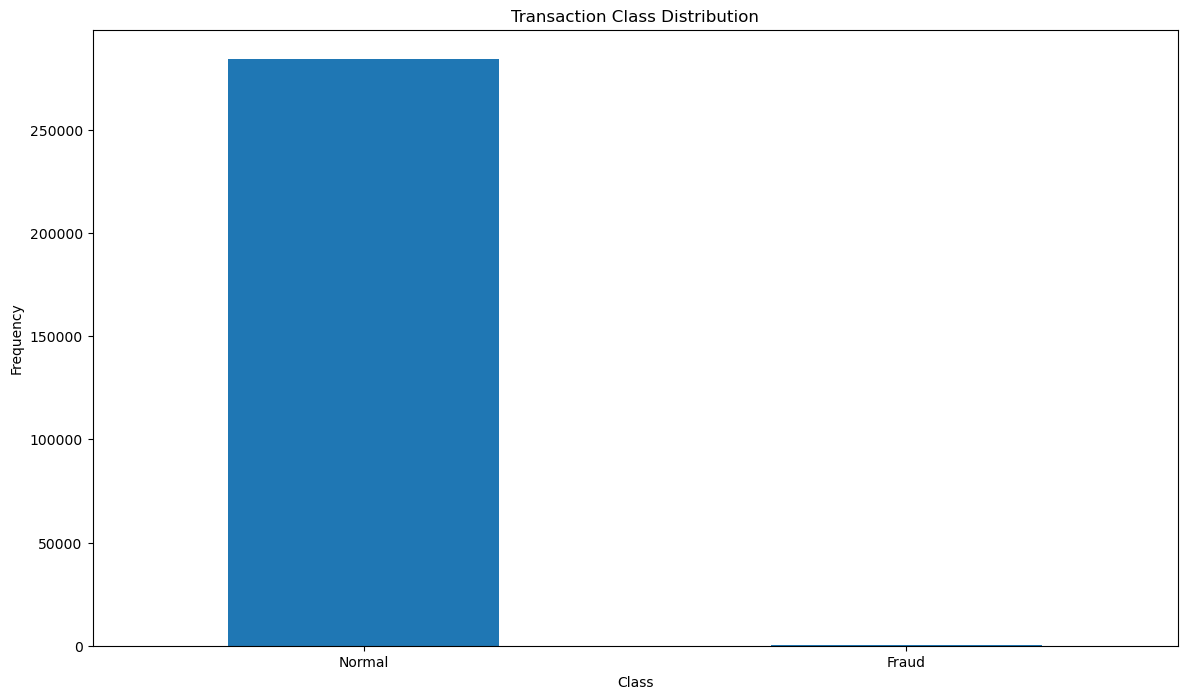

In [5]:
count_classes = pd.Series(data['Class']).value_counts()

count_classes.plot(kind = 'bar', rot=0)

plt.title("Transaction Class Distribution")

plt.xticks(range(2), LABELS)

plt.xlabel("Class")

plt.ylabel("Frequency")

Text(0, 0.5, 'Frequency')

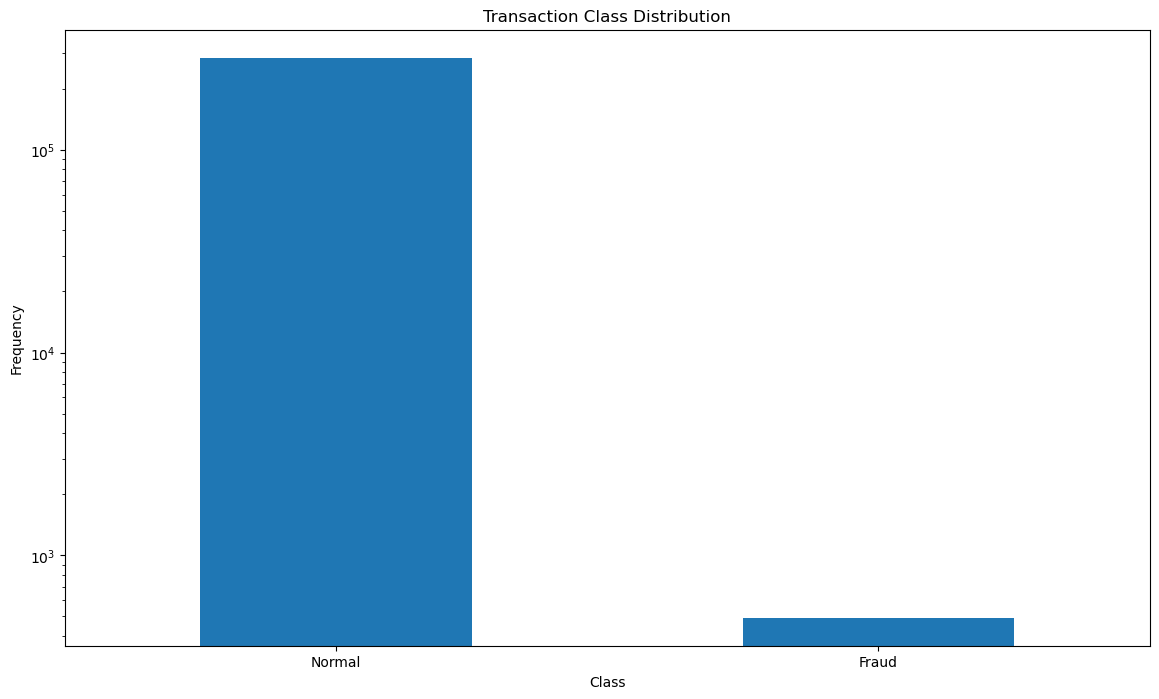

In [6]:
# Log scale
plt.yscale("log")

count_classes.plot(kind = 'bar', rot=0)

plt.title("Transaction Class Distribution")

plt.xticks(range(2), LABELS)

plt.xlabel("Class")

plt.ylabel("Frequency")

In [7]:
# Get the Fraud and the normal dataset 

fraud = data[data['Class']==1]
normal = data[data['Class']==0]
print(fraud.shape,normal.shape)


(492, 31) (284315, 31)


### Implementing Downsampling for Handling Imbalanced 

In [8]:
from imblearn.under_sampling import NearMiss
nm = NearMiss()
X_res,y_res=nm.fit_resample(X,Y) #generate new independent and dependent feature by downsampling
X_res.shape,y_res.shape

((984, 30), (984,))

In [9]:
from collections import Counter
print('Original dataset shape {}'.format(Counter(Y)))
print('Resampled dataset shape {}'.format(Counter(y_res)))

Original dataset shape Counter({0: 284315, 1: 492})
Resampled dataset shape Counter({0: 492, 1: 492})


However, loss information during this process. 

### Implementing Oversampling for Handling Imbalanced 

In [10]:
from imblearn.combine import SMOTETomek

smk = SMOTETomek() #Synthetic Minority Over-Sampling Technique
X_res,y_res=smk.fit_resample(X,Y)
X_res.shape,y_res.shape

((567518, 30), (567518,))

In [11]:
print('Original dataset shape {}'.format(Counter(Y)))
print('Resampled dataset shape {}'.format(Counter(y_res)))

Original dataset shape Counter({0: 284315, 1: 492})
Resampled dataset shape Counter({0: 283759, 1: 283759})


In [16]:
# RandomOverSampler to handle imbalanced data
from imblearn.over_sampling import RandomOverSampler
os =  RandomOverSampler(random_state=RANDOM_SEED) 
X_train_res, y_train_res = os.fit_resample(X, Y)
X_train_res.shape,y_train_res.shape

((568630, 30), (568630,))

In [17]:
print('Original dataset shape {}'.format(Counter(Y)))
print('Resampled dataset shape {}'.format(Counter(y_train_res)))

Original dataset shape Counter({0: 284315, 1: 492})
Resampled dataset shape Counter({0: 284315, 1: 284315})


### Acknowledgements

More details on current and past projects on related topics are available on https://www.researchgate.net/project/Fraud-detection-5 and the page of the DefeatFraud project.